In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

how do EPD and CAHOOTS arrival times vary by call priority, by time of day, by day of week, and by call type

# Cleaning

## Loading
Loading in and looking at dataframe

In [5]:
call_data = pd.read_csv("class_data_14-25.csv", dtype={"zip": str, "case_id": str})

In [6]:
call_data.head()

,yr,service,inci_id,calltime,case_id,callsource,nature,closecode,closed_as,secs_to_disp,secs_to_arrv,secs_to_close,disp,arrv,beat,priority,zip,primeunit,units_dispd,units_arrived
0,2014,LAW,14000001,2014-01-01 00:00:05.000,NaN,SELF,TRAFFIC STOP,UTC,UNIFORM TRAFFIC CITATION ISSUED,1.0,1.0,690,1,1,EP05,6,97402,5Z51,1,1
1,2014,LAW,14000003,2014-01-01 00:01:50.000,NaN,SELF,TRAFFIC STOP,ADVI,ADVISED,0.0,0.0,170,1,1,EP02,6,97401,5T82,2,2
2,2014,LAW,14000006,2014-01-01 00:05:17.000,NaN,PHONE,DISPUTE,ADVI,ADVISED,219.0,596.0,1444,1,1,EP01,3,97401,5E93,3,2
3,2014,LAW,14000007,2014-01-01 00:08:36.000,NaN,SELF,TRAFFIC STOP,WARN,WARNING,0.0,0.0,427,1,1,EP02,6,97401,5E31,2,2
4,2014,LAW,14000011,2014-01-01 00:10:21.000,NaN,E911,THEFT,RSLV,RESOLVED,168.0,380.0,1126,1,1,EP05,3,97402,6E45,2,2


In [7]:
call_data["service"].unique()

array(['LAW ', '    ', 'FIRE', 'OTHR'], dtype=object)

## Arrival, Dispatch, and Clear Times

It looks like dispatch, arrival, and close times are all in seconds, it would be much easier to read and compare if they were in minutes

In [10]:
call_data["dispatch_time"] = call_data["secs_to_disp"]/60
call_data["arrival_time"] = call_data["secs_to_arrv"]/60
call_data["clear_time"] = call_data["secs_to_close"]/60

In [11]:
call_data.head(5)

,yr,service,inci_id,calltime,case_id,callsource,nature,closecode,closed_as,secs_to_disp,...,arrv,beat,priority,zip,primeunit,units_dispd,units_arrived,dispatch_time,arrival_time,clear_time
0,2014,LAW,14000001,2014-01-01 00:00:05.000,NaN,SELF,TRAFFIC STOP,UTC,UNIFORM TRAFFIC CITATION ISSUED,1.0,...,1,EP05,6,97402,5Z51,1,1,0.016667,0.016667,11.500000
1,2014,LAW,14000003,2014-01-01 00:01:50.000,NaN,SELF,TRAFFIC STOP,ADVI,ADVISED,0.0,...,1,EP02,6,97401,5T82,2,2,0.000000,0.000000,2.833333
2,2014,LAW,14000006,2014-01-01 00:05:17.000,NaN,PHONE,DISPUTE,ADVI,ADVISED,219.0,...,1,EP01,3,97401,5E93,3,2,3.650000,9.933333,24.066667
3,2014,LAW,14000007,2014-01-01 00:08:36.000,NaN,SELF,TRAFFIC STOP,WARN,WARNING,0.0,...,1,EP02,6,97401,5E31,2,2,0.000000,0.000000,7.116667
4,2014,LAW,14000011,2014-01-01 00:10:21.000,NaN,E911,THEFT,RSLV,RESOLVED,168.0,...,1,EP05,3,97402,6E45,2,2,2.800000,6.333333,18.766667


## Identifying CAHOOT Calls

We need to identify which calls CAHOOTS responded too.
For the old data, CAHOOTS call signs are XJXX or some form of CAHOOTS abreviated (CAH, CAHOT, CAHOOT)

In [14]:
units = []
for i in call_data["primeunit"].astype(str).unique():
    units.append(i[1])

In [15]:
pd.Series(units).unique() == "J"

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [16]:
units = []
for i in call_data["primeunit"].astype(str).unique():
    if i[0] == "C":
        units.append(i)
units

['CMD10 ',
 'CAHOOT',
 'CMD2  ',
 'CMD6  ',
 'CMD9  ',
 'CNTR  ',
 'CMD5  ',
 'CMD4  ',
 'CMD1  ',
 'CNT   ',
 'C1    ',
 'CMD8  ',
 'CMD3  ',
 'CMD03 ',
 'CMD7  ',
 'C8    ',
 'CMD12 ',
 'CMD11 ',
 'CMD16 ',
 'CMD13 ',
 'C100  ',
 'CMD14 ']

It looks like for this dataset CAHOOT units are only labeled with 'CAHOOT'. Adding a boolean column if a call was a CAHOOT response or not

In [18]:
call_data["Service Type"] = (call_data["primeunit"] == "CAHOOT")
call_data["Service Type"] = call_data["Service Type"].replace(True, "CAHOOTS")
call_data["Service Type"] = call_data["Service Type"].replace(False, "EPD")

## Time of Day and Day of Week

Creating new columns that contain what hour of the day and day of the week the calls were place

In [21]:
call_data["Hour"] = pd.DatetimeIndex(call_data['calltime']).hour
call_data["DoW"] = pd.DatetimeIndex(call_data['calltime']).dayofweek

In [22]:
call_data.sample(n=5)

,yr,service,inci_id,calltime,case_id,callsource,nature,closecode,closed_as,secs_to_disp,...,zip,primeunit,units_dispd,units_arrived,dispatch_time,arrival_time,clear_time,Service Type,Hour,DoW
1421178,2024,LAW,24275189,2024-10-14 19:23:36.000,NaN,W911,DISPUTE,RSLV,RESOLVED,6324.0,...,97408,5U22,2,2,105.400000,112.316667,129.916667,EPD,19,0
189115,2015,LAW,15170473,2015-07-20 12:14:47.000,NaN,PHONE,OVERDOSE,ASST,ASSISTED,80.0,...,97404,1E69,3,2,1.333333,7.366667,32.033333,EPD,12,0
1321708,2024,OTHR,24015639,2024-01-16 14:40:16.000,NaN,PHONE,"TRANSPORT, CAHOOTS",UTL,UNABLE TO LOCATE,5017.0,...,97402,CAHOOT,1,1,83.616667,88.833333,93.616667,CAHOOTS,14,1
824732,2020,LAW,20133237,2020-05-30 20:44:28.000,NaN,PHONE,THEFT,DIS,DISREGARD,NaN,...,97404,NaN,0,0,NaN,NaN,2.733333,EPD,20,5
210860,2015,LAW,15226116,2015-09-20 02:24:17.000,NaN,SELF,TRAFFIC STOP,SBCK,SOBRIETY CHECK,0.0,...,97402,6E38,1,1,0.000000,0.000000,8.933333,EPD,2,6


## Filtering Data

We are only interested in calls where a unit was dispatched, arrived on scene, and cleared the call, so if any of this information is missing we fill filter that call out of the data we are working with

Additionally it is not possible for any of these times to be negative, so filtering for only times that are possible

In [25]:
call_data.dropna(subset = ['clear_time', 'arrival_time', 'dispatch_time'], inplace=True)
call_data = call_data[(call_data["clear_time"] >= 0)&(call_data["arrival_time"] >= 0)&(call_data["dispatch_time"] >= 0)]
call_data.head()

,yr,service,inci_id,calltime,case_id,callsource,nature,closecode,closed_as,secs_to_disp,...,zip,primeunit,units_dispd,units_arrived,dispatch_time,arrival_time,clear_time,Service Type,Hour,DoW
0,2014,LAW,14000001,2014-01-01 00:00:05.000,NaN,SELF,TRAFFIC STOP,UTC,UNIFORM TRAFFIC CITATION ISSUED,1.0,...,97402,5Z51,1,1,0.016667,0.016667,11.500000,EPD,0,2
1,2014,LAW,14000003,2014-01-01 00:01:50.000,NaN,SELF,TRAFFIC STOP,ADVI,ADVISED,0.0,...,97401,5T82,2,2,0.000000,0.000000,2.833333,EPD,0,2
2,2014,LAW,14000006,2014-01-01 00:05:17.000,NaN,PHONE,DISPUTE,ADVI,ADVISED,219.0,...,97401,5E93,3,2,3.650000,9.933333,24.066667,EPD,0,2
3,2014,LAW,14000007,2014-01-01 00:08:36.000,NaN,SELF,TRAFFIC STOP,WARN,WARNING,0.0,...,97401,5E31,2,2,0.000000,0.000000,7.116667,EPD,0,2
4,2014,LAW,14000011,2014-01-01 00:10:21.000,NaN,E911,THEFT,RSLV,RESOLVED,168.0,...,97402,6E45,2,2,2.800000,6.333333,18.766667,EPD,0,2


In [26]:
np.mean(call_data[call_data["callsource"] == "SELF"]["arrival_time"])

1.1083346741826956

In [27]:
call_data[call_data["callsource"] == "SELF"]["Service Type"].value_counts()

Service Type
EPD        360837
CAHOOTS      5846
Name: count, dtype: int64

Many of the arrival times are less than 1 minute and have the call source "SELF". These are also disproportionately calls not by CAHOOTS. Most of the natures are traffic stops and other types where its an officer seeing something and then arriving instantly as they are already on the scene. Filtering out these calls will give a better idea of how CAHOOTS and other services respond for calls where they are not already on scene

In [29]:
#call_data = call_data[call_data["callsource"] != "SELF"]

# Analysis

### Methods

In [32]:
CAHOOT = call_data[call_data["Service Type"] == "CAHOOTS"]
t = CAHOOT["nature"].value_counts()
natures = t[t>1000]
natures.index

Index(['ASSIST PUBLIC- POLICE', 'CHECK WELFARE', 'TRANSPORT',
       'PUBLIC ASSIST, CAHOOTS', 'CHECK WELFARE, CAHOOTS', 'SUICIDAL SUBJECT',
       'SUICIDAL SUBJECT, CAHOOTS', 'TRANSPORT, CAHOOTS',
       'INTOXICATED SUBJECT', 'ASSIST PD, CAHOOTS', 'DISORDERLY SUBJECT',
       'FOUND SYRINGE', 'TRAFFIC HAZARD', 'ASSIST FIRE DEPARTMENT'],
      dtype='object', name='nature')

In [33]:
def ttest(column, value, time_type,df = call_data):
    cahoot = df[(df["Service Type"] == "CAHOOTS") & (df[column] == value)][time_type]
    epd = df[(df["Service Type"] == "EPD") & (df[column] == value)][time_type]
    ttest_r = stats.ttest_ind(cahoot,epd)
    print(f"CAHOOT average {time_type} for {column} of {value} is: {round(np.mean(cahoot), 3)} min for {len(cahoot)} calls")
    print(f"EPD average {time_type} for {column} of {value} is: {round(np.mean(epd), 3)} min for {len(epd)} calls")
    print(f"Two sample t-test, t-stat: {round(ttest_r[0], 3)}, p-value: {round(ttest_r[1],5)}")
    return

In [34]:
ttest("Hour",10,"arrival_time")

CAHOOT average arrival_time for Hour of 10 is: 103.493 min for 6707 calls
EPD average arrival_time for Hour of 10 is: 46.885 min for 42871 calls
Two sample t-test, t-stat: 30.401, p-value: 0.0


### Arrival Times

(0.0, 140.0)

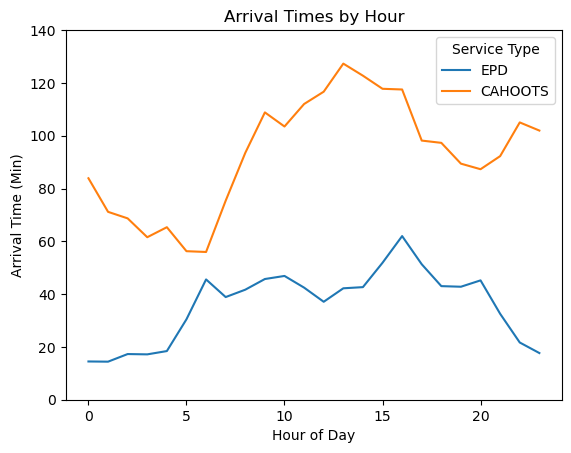

In [36]:
sns.lineplot(call_data, x = "Hour", y = "arrival_time", hue = "Service Type",errorbar=None)
plt.xlabel("Hour of Day")
plt.ylabel("Arrival Time (Min)")
plt.title('Arrival Times by Hour')
plt.ylim(0, 140)

In [37]:
for i in range(24):
    ttest("Hour",i,"arrival_time")

CAHOOT average arrival_time for Hour of 0 is: 83.889 min for 4612 calls
EPD average arrival_time for Hour of 0 is: 14.49 min for 35468 calls
Two sample t-test, t-stat: 74.506, p-value: 0.0
CAHOOT average arrival_time for Hour of 1 is: 71.167 min for 4064 calls
EPD average arrival_time for Hour of 1 is: 14.414 min for 29671 calls
Two sample t-test, t-stat: 57.932, p-value: 0.0
CAHOOT average arrival_time for Hour of 2 is: 68.689 min for 3339 calls
EPD average arrival_time for Hour of 2 is: 17.299 min for 22595 calls
Two sample t-test, t-stat: 40.828, p-value: 0.0
CAHOOT average arrival_time for Hour of 3 is: 61.553 min for 2510 calls
EPD average arrival_time for Hour of 3 is: 17.18 min for 16382 calls
Two sample t-test, t-stat: 34.635, p-value: 0.0
CAHOOT average arrival_time for Hour of 4 is: 65.346 min for 2216 calls
EPD average arrival_time for Hour of 4 is: 18.432 min for 13970 calls
Two sample t-test, t-stat: 30.613, p-value: 0.0
CAHOOT average arrival_time for Hour of 5 is: 56.261

(0.0, 140.0)

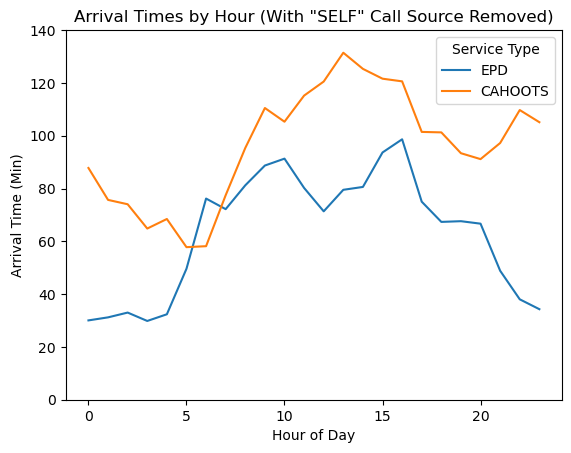

In [38]:
call_data = call_data[call_data["callsource"] != "SELF"]
sns.lineplot(call_data, x = "Hour", y = "arrival_time", hue = "Service Type",errorbar=None)
plt.xlabel("Hour of Day")
plt.ylabel("Arrival Time (Min)")
plt.title('Arrival Times by Hour (With "SELF" Call Source Removed)')
plt.ylim(0, 140)

In [39]:
for i in range(24):
    ttest("Hour",i,"arrival_time")

CAHOOT average arrival_time for Hour of 0 is: 83.889 min for 4612 calls
EPD average arrival_time for Hour of 0 is: 14.49 min for 35468 calls
Two sample t-test, t-stat: 74.506, p-value: 0.0
CAHOOT average arrival_time for Hour of 1 is: 71.167 min for 4064 calls
EPD average arrival_time for Hour of 1 is: 14.414 min for 29671 calls
Two sample t-test, t-stat: 57.932, p-value: 0.0
CAHOOT average arrival_time for Hour of 2 is: 68.689 min for 3339 calls
EPD average arrival_time for Hour of 2 is: 17.299 min for 22595 calls
Two sample t-test, t-stat: 40.828, p-value: 0.0
CAHOOT average arrival_time for Hour of 3 is: 61.553 min for 2510 calls
EPD average arrival_time for Hour of 3 is: 17.18 min for 16382 calls
Two sample t-test, t-stat: 34.635, p-value: 0.0
CAHOOT average arrival_time for Hour of 4 is: 65.346 min for 2216 calls
EPD average arrival_time for Hour of 4 is: 18.432 min for 13970 calls
Two sample t-test, t-stat: 30.613, p-value: 0.0
CAHOOT average arrival_time for Hour of 5 is: 56.261

In [40]:
df_sorted = call_data
df_sorted = df_sorted.sort_values('DoW')

In [41]:
df_sorted['DoW'] = df_sorted['DoW'].replace(0, 'Mon')
df_sorted['DoW'] = df_sorted['DoW'].replace(1, 'Tues')
df_sorted['DoW'] = df_sorted['DoW'].replace(2, 'Wed')
df_sorted['DoW'] = df_sorted['DoW'].replace(3, 'Thurs')
df_sorted['DoW'] = df_sorted['DoW'].replace(4, 'Fri')
df_sorted['DoW'] = df_sorted['DoW'].replace(5, 'Sat')
df_sorted['DoW'] = df_sorted['DoW'].replace(6, 'Sun')

Text(0.5, 1.0, 'Arrival Times by Day of The Week')

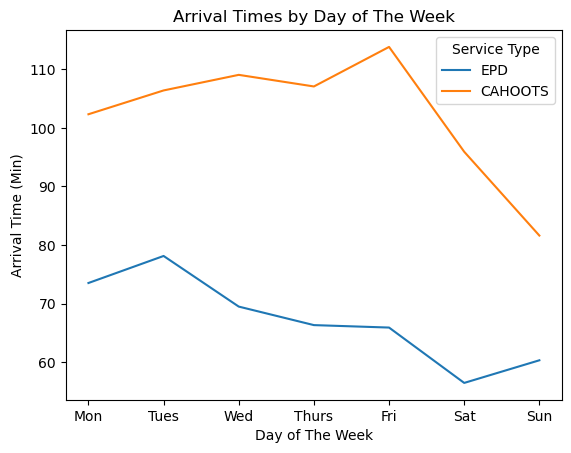

In [42]:
DoW_order = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
sns.lineplot(df_sorted, x = "DoW", y = "arrival_time", hue = "Service Type",errorbar=None) #, order = DoW_order
plt.xlabel("Day of The Week")
plt.ylabel("Arrival Time (Min)")
plt.title("Arrival Times by Day of The Week")

In [43]:
for i in range(7):
    ttest("DoW",i,"arrival_time")

CAHOOT average arrival_time for DoW of 0 is: 99.242 min for 20701 calls
EPD average arrival_time for DoW of 0 is: 44.641 min for 105239 calls
Two sample t-test, t-stat: 52.672, p-value: 0.0
CAHOOT average arrival_time for DoW of 1 is: 103.118 min for 20079 calls
EPD average arrival_time for DoW of 1 is: 42.787 min for 114771 calls
Two sample t-test, t-stat: 58.154, p-value: 0.0
CAHOOT average arrival_time for DoW of 2 is: 105.474 min for 19963 calls
EPD average arrival_time for DoW of 2 is: 36.849 min for 124686 calls
Two sample t-test, t-stat: 72.219, p-value: 0.0
CAHOOT average arrival_time for DoW of 3 is: 103.689 min for 20007 calls
EPD average arrival_time for DoW of 3 is: 34.431 min for 130274 calls
Two sample t-test, t-stat: 79.948, p-value: 0.0
CAHOOT average arrival_time for DoW of 4 is: 110.047 min for 19860 calls
EPD average arrival_time for DoW of 4 is: 35.248 min for 130712 calls
Two sample t-test, t-stat: 82.43, p-value: 0.0
CAHOOT average arrival_time for DoW of 5 is: 91

Text(0.5, 1.0, 'Arrival Times by Call Priority')

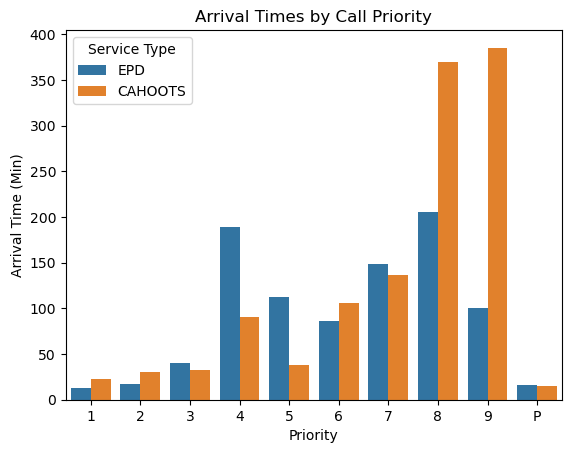

In [44]:
orders =  ["1", "2", "3", "4", "5", "6", "7", "8", "9", "P"]
sns.barplot(call_data, x = "priority", y = "arrival_time", hue = "Service Type", order = orders, errorbar = None)
plt.xlabel("Priority")
plt.ylabel("Arrival Time (Min)")
plt.title("Arrival Times by Call Priority")

In [45]:
for i in orders:
    ttest("priority",i,"arrival_time")

CAHOOT average arrival_time for priority of 1 is: 21.361 min for 3985 calls
EPD average arrival_time for priority of 1 is: 11.747 min for 36397 calls
Two sample t-test, t-stat: 26.1, p-value: 0.0
CAHOOT average arrival_time for priority of 2 is: 30.736 min for 28 calls
EPD average arrival_time for priority of 2 is: 17.413 min for 3899 calls
Two sample t-test, t-stat: 1.786, p-value: 0.07413
CAHOOT average arrival_time for priority of 3 is: 32.816 min for 11328 calls
EPD average arrival_time for priority of 3 is: 40.396 min for 276704 calls
Two sample t-test, t-stat: -10.795, p-value: 0.0
CAHOOT average arrival_time for priority of 4 is: 90.318 min for 183 calls
EPD average arrival_time for priority of 4 is: 188.796 min for 55580 calls
Two sample t-test, t-stat: -5.341, p-value: 0.0
CAHOOT average arrival_time for priority of 5 is: 37.725 min for 34261 calls
EPD average arrival_time for priority of 5 is: 111.951 min for 58884 calls
Two sample t-test, t-stat: -61.09, p-value: 0.0
CAHOOT 

In [46]:
nats = call_data[call_data["nature"].isin(['ASSIST PUBLIC- POLICE', 'CHECK WELFARE', 'TRANSPORT',
       'PUBLIC ASSIST, CAHOOTS', 'CHECK WELFARE, CAHOOTS', 'SUICIDAL SUBJECT',
       'SUICIDAL SUBJECT, CAHOOTS', 'TRANSPORT, CAHOOTS',
       'INTOXICATED SUBJECT', 'ASSIST PD, CAHOOTS', 'DISORDERLY SUBJECT',
       'FOUND SYRINGE', 'TRAFFIC HAZARD', 'ASSIST FIRE DEPARTMENT'])]

Text(0.5, 1.0, 'Arrival Times by Call Nature')

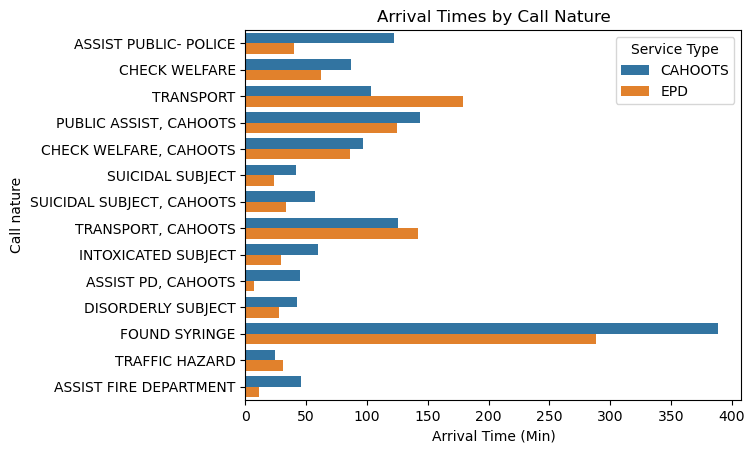

In [47]:
nat_order = ['ASSIST PUBLIC- POLICE', 'CHECK WELFARE', 'TRANSPORT',
       'PUBLIC ASSIST, CAHOOTS', 'CHECK WELFARE, CAHOOTS', 'SUICIDAL SUBJECT',
       'SUICIDAL SUBJECT, CAHOOTS', 'TRANSPORT, CAHOOTS',
       'INTOXICATED SUBJECT', 'ASSIST PD, CAHOOTS', 'DISORDERLY SUBJECT',
       'FOUND SYRINGE', 'TRAFFIC HAZARD', 'ASSIST FIRE DEPARTMENT']
sns.barplot(nats, y = "nature", x = "arrival_time", hue = "Service Type", order = nat_order, errorbar = None)
plt.ylabel("Call nature")
plt.xlabel("Arrival Time (Min)")
plt.title("Arrival Times by Call Nature")

In [48]:
for i in nat_order:
    ttest("nature",i,"arrival_time", df = nats)

CAHOOT average arrival_time for nature of ASSIST PUBLIC- POLICE is: 122.364 min for 30638 calls
EPD average arrival_time for nature of ASSIST PUBLIC- POLICE is: 40.239 min for 4381 calls
Two sample t-test, t-stat: 36.028, p-value: 0.0
CAHOOT average arrival_time for nature of CHECK WELFARE is: 86.874 min for 30055 calls
EPD average arrival_time for nature of CHECK WELFARE is: 62.492 min for 28123 calls
Two sample t-test, t-stat: 24.682, p-value: 0.0
CAHOOT average arrival_time for nature of TRANSPORT is: 103.114 min for 20470 calls
EPD average arrival_time for nature of TRANSPORT is: 179.304 min for 721 calls
Two sample t-test, t-stat: -16.981, p-value: 0.0
CAHOOT average arrival_time for nature of PUBLIC ASSIST, CAHOOTS is: 143.852 min for 12991 calls
EPD average arrival_time for nature of PUBLIC ASSIST, CAHOOTS is: 124.74 min for 10 calls
Two sample t-test, t-stat: 0.356, p-value: 0.72149
CAHOOT average arrival_time for nature of CHECK WELFARE, CAHOOTS is: 96.791 min for 11374 calls


Cahoots appears to be slower in most cases than EPD but it could be because Cahoots does not have access to sirens

### Clear Times

(0.0, 170.0)

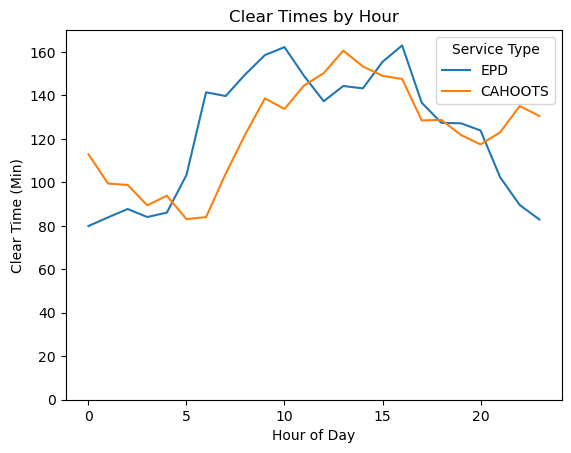

In [51]:
sns.lineplot(call_data, x = "Hour", y = "clear_time", hue = "Service Type",errorbar=None)
plt.xlabel("Hour of Day")
plt.ylabel("Clear Time (Min)")
plt.title("Clear Times by Hour")
plt.ylim(0, 170)

In [52]:
for i in range(24):
    ttest("Hour",i,"clear_time")

CAHOOT average clear_time for Hour of 0 is: 108.882 min for 4612 calls
EPD average clear_time for Hour of 0 is: 52.951 min for 35468 calls
Two sample t-test, t-stat: 36.942, p-value: 0.0
CAHOOT average clear_time for Hour of 1 is: 94.836 min for 4064 calls
EPD average clear_time for Hour of 1 is: 55.132 min for 29671 calls
Two sample t-test, t-stat: 22.746, p-value: 0.0
CAHOOT average clear_time for Hour of 2 is: 93.287 min for 3339 calls
EPD average clear_time for Hour of 2 is: 62.598 min for 22595 calls
Two sample t-test, t-stat: 15.059, p-value: 0.0
CAHOOT average clear_time for Hour of 3 is: 85.954 min for 2510 calls
EPD average clear_time for Hour of 3 is: 60.479 min for 16382 calls
Two sample t-test, t-stat: 11.959, p-value: 0.0
CAHOOT average clear_time for Hour of 4 is: 90.42 min for 2216 calls
EPD average clear_time for Hour of 4 is: 59.57 min for 13970 calls
Two sample t-test, t-stat: 7.668, p-value: 0.0
CAHOOT average clear_time for Hour of 5 is: 81.288 min for 2637 calls
EP

Text(0.5, 1.0, 'Clear Times by Day of The Week')

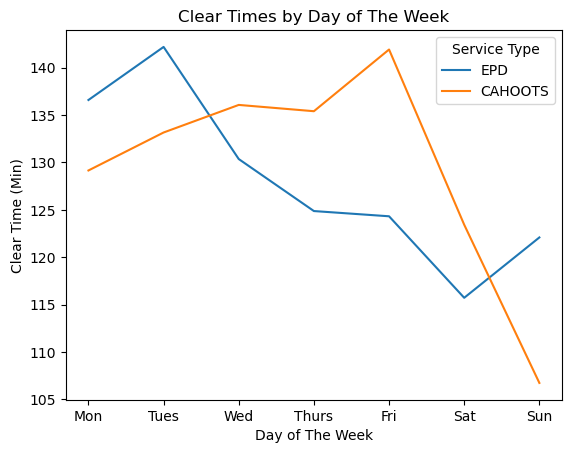

In [53]:
sns.lineplot(df_sorted, x = "DoW", y = "clear_time", hue = "Service Type",errorbar=None) #, order = DoW_order
plt.xlabel("Day of The Week")
plt.ylabel("Clear Time (Min)")
plt.title("Clear Times by Day of The Week")

In [54]:
for i in range(7):
    ttest("DoW",i,"clear_time")

CAHOOT average clear_time for DoW of 0 is: 125.958 min for 20701 calls
EPD average clear_time for DoW of 0 is: 95.253 min for 105239 calls
Two sample t-test, t-stat: 24.204, p-value: 0.0
CAHOOT average clear_time for DoW of 1 is: 129.852 min for 20079 calls
EPD average clear_time for DoW of 1 is: 93.163 min for 114771 calls
Two sample t-test, t-stat: 26.508, p-value: 0.0
CAHOOT average clear_time for DoW of 2 is: 132.512 min for 19963 calls
EPD average clear_time for DoW of 2 is: 84.921 min for 124686 calls
Two sample t-test, t-stat: 39.21, p-value: 0.0
CAHOOT average clear_time for DoW of 3 is: 132.177 min for 20007 calls
EPD average clear_time for DoW of 3 is: 80.272 min for 130274 calls
Two sample t-test, t-stat: 46.721, p-value: 0.0
CAHOOT average clear_time for DoW of 4 is: 138.068 min for 19860 calls
EPD average clear_time for DoW of 4 is: 80.843 min for 130712 calls
Two sample t-test, t-stat: 49.821, p-value: 0.0
CAHOOT average clear_time for DoW of 5 is: 119.431 min for 20046 c

Text(0.5, 1.0, 'Clear Times by Call Priority')

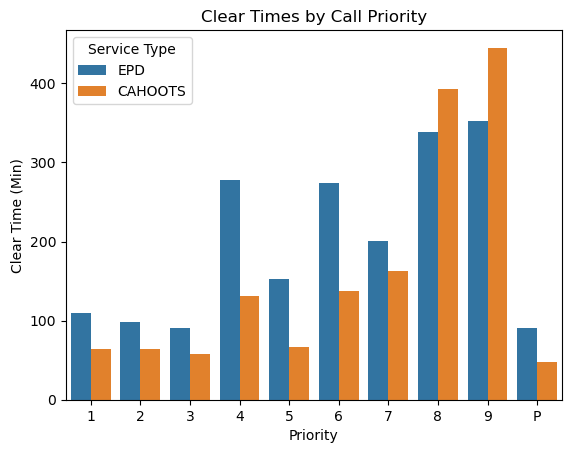

In [55]:
orders =  ["1", "2", "3", "4", "5", "6", "7", "8", "9", "P"]
sns.barplot(call_data, x = "priority", y = "clear_time", hue = "Service Type", order = orders, errorbar = None)
plt.xlabel("Priority")
plt.ylabel("Clear Time (Min)")
plt.title("Clear Times by Call Priority")

In [56]:
for i in orders:
    ttest("priority",i,"clear_time")

CAHOOT average clear_time for priority of 1 is: 62.603 min for 3985 calls
EPD average clear_time for priority of 1 is: 104.898 min for 36397 calls
Two sample t-test, t-stat: -14.597, p-value: 0.0
CAHOOT average clear_time for priority of 2 is: 63.924 min for 28 calls
EPD average clear_time for priority of 2 is: 97.902 min for 3899 calls
Two sample t-test, t-stat: -1.493, p-value: 0.13557
CAHOOT average clear_time for priority of 3 is: 57.803 min for 11328 calls
EPD average clear_time for priority of 3 is: 91.154 min for 276704 calls
Two sample t-test, t-stat: -31.606, p-value: 0.0
CAHOOT average clear_time for priority of 4 is: 131.353 min for 183 calls
EPD average clear_time for priority of 4 is: 277.102 min for 55580 calls
Two sample t-test, t-stat: -7.266, p-value: 0.0
CAHOOT average clear_time for priority of 5 is: 65.412 min for 34261 calls
EPD average clear_time for priority of 5 is: 152.582 min for 58884 calls
Two sample t-test, t-stat: -60.188, p-value: 0.0
CAHOOT average clear

Text(0.5, 1.0, 'Clear Times by Call Nature')

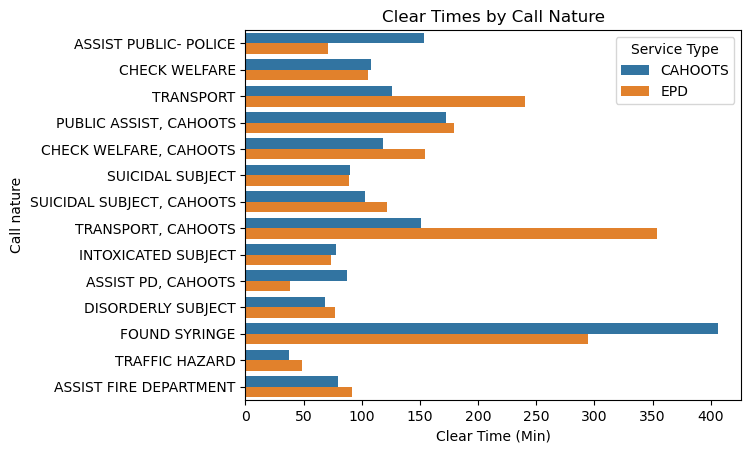

In [57]:
nat_order = ['ASSIST PUBLIC- POLICE', 'CHECK WELFARE', 'TRANSPORT',
       'PUBLIC ASSIST, CAHOOTS', 'CHECK WELFARE, CAHOOTS', 'SUICIDAL SUBJECT',
       'SUICIDAL SUBJECT, CAHOOTS', 'TRANSPORT, CAHOOTS',
       'INTOXICATED SUBJECT', 'ASSIST PD, CAHOOTS', 'DISORDERLY SUBJECT',
       'FOUND SYRINGE', 'TRAFFIC HAZARD', 'ASSIST FIRE DEPARTMENT']
sns.barplot(nats, y = "nature", x = "clear_time", hue = "Service Type", order = nat_order, errorbar = None)
plt.ylabel("Call nature")
plt.xlabel("Clear Time (Min)")
plt.title("Clear Times by Call Nature")

In [58]:
for i in nat_order:
    ttest("nature",i,"clear_time", df = nats)

CAHOOT average clear_time for nature of ASSIST PUBLIC- POLICE is: 153.398 min for 30638 calls
EPD average clear_time for nature of ASSIST PUBLIC- POLICE is: 71.075 min for 4381 calls
Two sample t-test, t-stat: 34.912, p-value: 0.0
CAHOOT average clear_time for nature of CHECK WELFARE is: 108.345 min for 30055 calls
EPD average clear_time for nature of CHECK WELFARE is: 105.285 min for 28123 calls
Two sample t-test, t-stat: 2.655, p-value: 0.00793
CAHOOT average clear_time for nature of TRANSPORT is: 126.059 min for 20470 calls
EPD average clear_time for nature of TRANSPORT is: 240.785 min for 721 calls
Two sample t-test, t-stat: -25.284, p-value: 0.0
CAHOOT average clear_time for nature of PUBLIC ASSIST, CAHOOTS is: 172.796 min for 12991 calls
EPD average clear_time for nature of PUBLIC ASSIST, CAHOOTS is: 179.377 min for 10 calls
Two sample t-test, t-stat: -0.12, p-value: 0.90459
CAHOOT average clear_time for nature of CHECK WELFARE, CAHOOTS is: 118.151 min for 11374 calls
EPD average

## Call Volume Impact on time

In [60]:
CAH_df = call_data[call_data["Service Type"] == "CAHOOTS"]
avg_at_df = CAH_df.groupby("Hour")["arrival_time"].mean().reset_index()
avg_at_df

,Hour,arrival_time
0,0,87.783906
1,1,75.689820
2,2,74.042615
3,3,64.839866
4,4,68.458456
5,5,57.791347
6,6,58.156550
7,7,77.477240
8,8,95.371227
9,9,110.496597


In [61]:
count = len(CAH_df.groupby(pd.to_datetime(CAH_df['calltime']).dt.date))
counts_df = CAH_df.groupby("Hour").size().reset_index()
counts_df[0] = counts_df[0]/count
avg_at_df["avg_count"] = counts_df[0]
avg_at_df

,Hour,arrival_time,avg_count
0,0,87.783906,1.063887
1,1,75.689820,0.920995
2,2,74.042615,0.750061
3,3,64.839866,0.576689
4,4,68.458456,0.512802
5,5,57.791347,0.622287
6,6,58.156550,0.758839
7,7,77.477240,0.904414
8,8,95.371227,1.113875
9,9,110.496597,1.332846


Text(0.5, 0, 'Hour of Day')

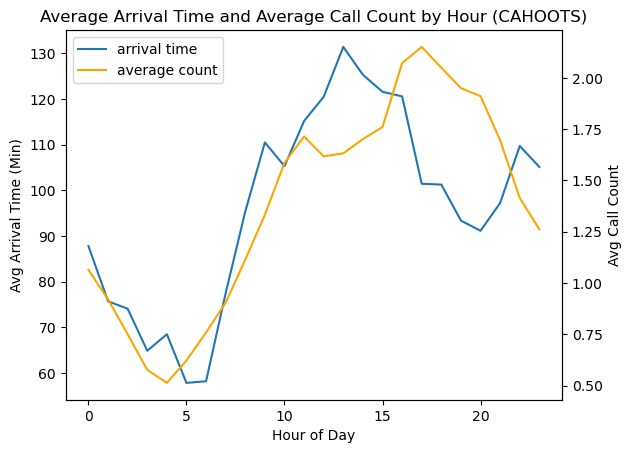

In [62]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.lineplot(avg_at_df, x = "Hour", y = "arrival_time", ax = ax1, label = "arrival time")
sns.lineplot(avg_at_df, x = "Hour", y = "avg_count", ax = ax2, color = "orange")
lines1 = ax1.lines
lines2 = ax2.lines
all_lines = lines1 + lines2
labels = ["arrival time", "average count"]
ax1.legend(all_lines, labels, loc="upper left")
ax1.set_title("Average Arrival Time and Average Call Count by Hour (CAHOOTS)")
ax1.set_ylabel("Avg Arrival Time (Min)")
ax2.set_ylabel("Avg Call Count")
ax1.set_xlabel("Hour of Day")

In [63]:
avg_at_df.corr()

,Hour,arrival_time,avg_count
Hour,1.000000,0.584697,0.761750
arrival_time,0.584697,1.000000,0.765485
avg_count,0.761750,0.765485,1.000000


In [64]:
CAH_df = CAH_df.copy()
CAH_df.loc[:, 'hour'] = pd.to_datetime(CAH_df['calltime']).dt.floor('h')
summary = CAH_df.groupby('hour').agg( call_count=('arrival_time', 'count'), avg_arrival_time=('arrival_time', 'mean')).reset_index()

In [65]:
summary["avg_arrival_time"] = summary["avg_arrival_time"].replace(0, 0.001)
summary2 = summary[(summary["avg_arrival_time"] > 0)]#(summary["avg_arrival_time"] < 1440) & 
summary2 = summary2.copy()
summary2["avg_arrival_time"] = np.log(summary2["avg_arrival_time"])#summary2.copy()
jit = 1
summary2["count_jit"] = summary2["call_count"] + np.random.uniform(-jit, jit, size=len(summary2["call_count"]))

Text(0.5, 1.0, 'Log Arrival time by Calls per Hour (CAHOOTS)')

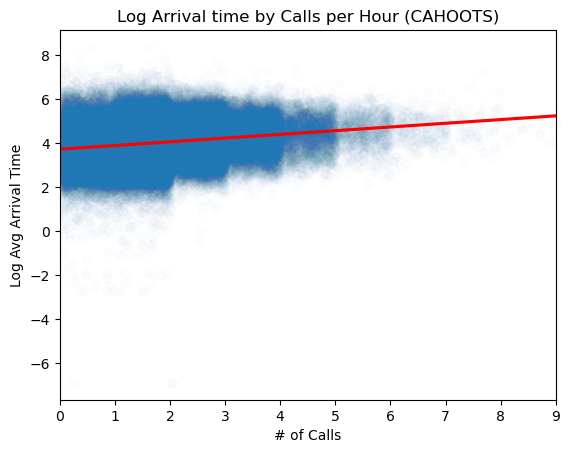

In [66]:
sns.regplot(summary2, x = "count_jit", y = "avg_arrival_time",line_kws={'color': 'red'}, scatter_kws={'alpha': 0.01}) #count_jit
#plt.ylim(0,400)
plt.xlim(0, 9)
plt.xlabel("# of Calls")
plt.ylabel("Log Avg Arrival Time")
plt.title("Log Arrival time by Calls per Hour (CAHOOTS)")